In [1]:
from qiskit import *
from mimiqcircuits import *
MIMIQ = False

# _**QAOA on WEIGHTED MAX CUT (WMC) problem**_
Let us have a graph (smart city) $G=(V,E)$, we want to find the max weight cut of the graph. The integer linear program associated is:
$$
\max_x \sum_{(i,j)\in E}w_{ij}|x_i-x_j|
$$
Where $w:E\rightarrow \mathbb R$ is the weight function and $x_i\in\{0,1\}$ defines if the node $i$ is in the vertex cover or not.

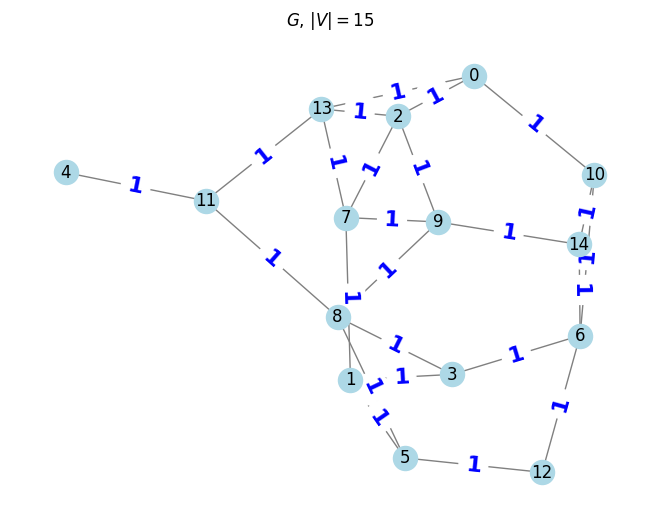

{(1, 0): 0, (2, 0): 1, (2, 1): 0, (3, 0): 0, (3, 1): 1, (3, 2): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (5, 0): 0, (5, 1): 1, (5, 2): 0, (5, 3): 0, (5, 4): 0, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 3): 1, (6, 4): 0, (6, 5): 0, (7, 0): 0, (7, 1): 1, (7, 2): 1, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0, (8, 0): 0, (8, 1): 0, (8, 2): 0, (8, 3): 1, (8, 4): 0, (8, 5): 1, (8, 6): 0, (8, 7): 0, (9, 0): 0, (9, 1): 0, (9, 2): 1, (9, 3): 0, (9, 4): 0, (9, 5): 0, (9, 6): 0, (9, 7): 1, (9, 8): 1, (10, 0): 1, (10, 1): 0, (10, 2): 0, (10, 3): 0, (10, 4): 0, (10, 5): 0, (10, 6): 1, (10, 7): 0, (10, 8): 0, (10, 9): 0, (11, 0): 0, (11, 1): 0, (11, 2): 0, (11, 3): 0, (11, 4): 1, (11, 5): 0, (11, 6): 0, (11, 7): 0, (11, 8): 1, (11, 9): 0, (11, 10): 0, (12, 0): 0, (12, 1): 0, (12, 2): 0, (12, 3): 0, (12, 4): 0, (12, 5): 1, (12, 6): 1, (12, 7): 0, (12, 8): 0, (12, 9): 0, (12, 10): 0, (12, 11): 0, (13, 0): 1, (13, 1): 0, (13, 2): 1, (13, 3): 0, (13, 4): 0, (13, 5): 0, (13, 6): 0, (13, 7): 1, (13, 8): 

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Let's first define the graph
n = 15
threshold = 0.2
edges = []
weights = {}
for i in range(n):
    for j in range(i):
        weights[(i, j)] = 0
        if np.random.rand() < threshold:
            edges.append((i, j))
            weights[(i, j)] = round(10*np.random.random())
            weights[(i, j)] = 1


# Visualize it
G = nx.Graph()
for e in edges:
    G.add_edge(e[0], e[1], weight=weights[e])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
edge_labels = dict([((n1, n2), d['weight'])
                    for n1, n2, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='blue', font_size=16, font_weight='bold')
plt.title(f"$G$, $|V|={n}$")
plt.show()
print(weights)

### **_1.1. MAXCUT QUBO_**
To use QAOA, we need a QUBO definition of our problem, which translates to:
$$
\min_x\sum_{(i,j)\in E}-w_{ij}|x_i-x_j|=\min_x\sum_{(i,j)\in E}w_{ij}(2x_ix_j-x_i-x_j)
$$
Which translates to minimizing the cost hamiltonian:
$$
H_C=\frac{1}{2}\sum_{(i,j)\in E}w_{ij}(Z_iZ_j-1)
$$
The ground state $|x_1,...,x_n\rangle$ will encode $x_i=1$ in the partition, else, not. Let's compute now the associated QAOA circuit, with evolution gate $U_C=e^{-i\gamma H_C}$, mixed with $U_M=e^{-i\beta H_M}$ $(H_M=\sum_i X_i)$.

In [22]:
# Circuit of the layer
def qaoa_layer(gamma, beta):
    if MIMIQ:
        c = Circuit()
        c.push(GateH(), range(n))
        for i, j in edges:
            c.push(GateRZZ(gamma), i, j)
        c.push(GateRX(2*beta), range(n))
        return c

    c = QuantumCircuit(n, n)
    c.h(range(n))
    for i, j in edges:
        c.rzz(gamma, i, j)
    c.rx(2*beta, range(n))
    return c

In [23]:
# Whole circuit
def qaoa_circ(gammas, betas, n_layers):
    if MIMIQ:
        c = Circuit()
        for i in range(n_layers):
            c.append(qaoa_layer(gammas[i], betas[i]))
        return c
    
    c = QuantumCircuit(n, n)
    for i in range(n_layers):
        c = c.compose(qaoa_layer(gammas[i], betas[i]), range(n))
    c.measure(range(n), range(n))
    return c

### **_1.2. Optimizing, to find MAXCUT_**

In [30]:
def single_cost(bitstring):
    cost = 0
    for i, j in edges:
        if bitstring[i] != bitstring[j]:
            cost -= weights[(i, j)]
    return cost

In [46]:
n_layers = 2*n
n_shots = 2048

In [ ]:
from qiskit_aer import AerSimulator
simulator_aer = AerSimulator()
def qiskit_cost_function(params):
    gammas = []
    betas = []
    for i in range(n_layers):
        gammas.append(params[i])
        betas.append(params[n_layers+i])
    qc = qaoa_circ(gammas, betas, n_layers)
    qc_aer = transpile(qc, backend=simulator_aer)
    result = simulator_aer.run(qc_aer, shots=n_shots).result()
    counts = result.get_counts()

    expectation = 0
    for bs in counts:
        # Recall that in QISKIT, the qubits are ranged from right to left, so we reverse it first
        bl = list(bs)
        bl.reverse()
        expectation += single_cost(bl)*counts[bs]
    return expectation/n_shots

In [22]:
# Connection
conn = MimiqConnection(url="https://mimiq.qperfect.io/api")
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 657/3000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [31]:
def mimiq_cost_function(params):
    gammas = []
    betas = []
    for i in range(n_layers):
        gammas.append(params[i])
        betas.append(params[n_layers+i])
    qc = qaoa_circ(gammas, betas, n_layers)
    j_id = conn.execute(qc, nsamples=n_shots)
    while True:
        if conn.isJobDone(j_id):
            break
    res = conn.get_result(j_id)
    expectation = 0
    for bs in res.cstates:
        expectation += single_cost(bs)
    return expectation/n_shots

    expectation = 0
    for bs in counts:
        # Recall that in QISKIT, the qubits are ranged from right to left, so we reverse it first
        bl = list(bs)
        bl.reverse()
        expectation += single_cost(bl)*counts[bs]
    return expectation/n_shots

In [ ]:
from scipy.optimize import minimize
import numpy as np
#initial_params = np.pi/2*(2*np.random.rand(n_layers*2)-1)
initial_params = [np.pi/4]*n_layers*2
result = minimize(qiskit_cost_function, initial_params, method="COBYLA")
optimal_gammas = []
optimal_betas = []
for i in range(n_layers):
    optimal_gammas.append(result.x[i])
    optimal_betas.append(result.x[n_layers+i])

In [44]:
from qiskit.visualization import plot_histogram

final_circ = qaoa_circ(optimal_gammas, optimal_betas, n_layers)
qc_aer = transpile(final_circ, backend=simulator_aer)
result = simulator_aer.run(qc_aer, shots=n_shots).result()
counts = result.get_counts()
#plot_histogram(counts)

Remembering that Qiskit encodes qubits from right to left, we reverse the bitstrings for understanding

In [45]:
solutions = []
sorted_bs = sorted(counts.items(), key=lambda i: i[1], reverse=True)
for point in sorted_bs:
    rev_bs = list(point[0])
    rev_bs.reverse()
    solutions.append(("".join(rev_bs), point[1], single_cost(rev_bs)))
solutions[:1000]

[('10110101010111011110', 2, -190),
 ('10101110011010010000', 2, -197),
 ('10001000010100010011', 1, -203),
 ('10101101011011000010', 1, -171),
 ('11100110011011100100', 1, -241),
 ('00101111111010000110', 1, -213),
 ('11010111101101100011', 1, -175),
 ('10000100100110110100', 1, -215),
 ('00110100100101101101', 1, -222),
 ('00001010100110101010', 1, -163),
 ('00111011010101001011', 1, -206),
 ('10000101111111101001', 1, -227),
 ('01110010111001111000', 1, -252),
 ('10001000001100110001', 1, -214),
 ('10100111011111001101', 1, -175),
 ('01001001100100111001', 1, -212),
 ('10100000101011010000', 1, -176),
 ('10010100011110001000', 1, -197),
 ('10111110111000010110', 1, -273),
 ('01110010100111100111', 1, -190),
 ('00110001101100011110', 1, -206),
 ('10110001110101000010', 1, -239),
 ('11011000010101101110', 1, -182),
 ('01001101101100000101', 1, -202),
 ('10001011010010111101', 1, -234),
 ('11010010011000001000', 1, -177),
 ('01111110001010111001', 1, -192),
 ('01101000011000000110', 1,

### **_1.3. MAXCUT to MVC_**
Now that we know our maxcuts, we need to convert them to vertex covers

In [164]:
covers = []
for s in solutions:
    cover = list(filter(lambda i: s[0][i]=='1', range(n)))
    # The partition is by convention the larger set, as we want the complement, we keep the smallest one
    if len(cover) > n*0.5:
        cover = list(set(range(n)) - set(cover))
    covers.append(cover)
covers[:5]

[[3, 4], [3, 4], [4], [4], [1, 3]]